## https://docs.oceanparcels.org/en/latest/examples/tutorial_croco_3D.html
## https://virtualfleet.readthedocs.io/en/latest/

In [12]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
import parcels
from parcels import FieldSet, Field, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, Variable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

sys.path.insert(0, os.path.abspath(os.path.join(".")))
from virtualargofleet import Velocity, VirtualFleet, FloatConfiguration, VelocityField

In [8]:
def AdvectionRK4_CrocoKevin(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration."""
    zs = -1*(particle.depth / fieldset.H[time, 0, particle.lat, particle.lon])
    (u1, v1) = fieldset.UV[time + 0.5 * particle.dt, zs, particle.lat, particle.lon]
    lon1, lat1 = (particle.lon + u1 * 0.5 * particle.dt, particle.lat + v1 * 0.5 * particle.dt)
    (u2, v2) = fieldset.UV[time + 0.5 * particle.dt, zs, lat1, lon1]
    lon2, lat2 = (particle.lon + u2 * 0.5 * particle.dt, particle.lat + v2 * 0.5 * particle.dt)
    (u3, v3) = fieldset.UV[time + 0.5 * particle.dt, zs, lat2, lon2]
    lon3, lat3 = (particle.lon + u3 * particle.dt, particle.lat + v3 * particle.dt)
    (u4, v4) = fieldset.UV[time + particle.dt, zs, lat3, lon3]
    particle_dlon += (u1 + 2 * u2 + 2 * u3 + u4) / 6.0 * particle.dt  # noqa
    particle_dlat += (v1 + 2 * v2 + 2 * v3 + v4) / 6.0 * particle.dt  # noqa

In [13]:
class ArgoParticle(JITParticle):
    """ Default class to represent an Argo float

    :class:`ArgoParticle` inherits from :class:`parcels.particle.JITParticle`.

    A :class:`.VirtualFleet` will create and work with a :class:`parcels.particleset.particlesetsoa.ParticleSetSOA`
    of this class.

    Returns
    -------
    :class:`parcels.particle.JITParticle`
    """
    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0, to_write=True)
    """Cycle phase (init_descend = 0, drift = 1, profile_descend = 2, profile_ascend = 3, transmit = 4)"""

    cycle_number = Variable('cycle_number', dtype=np.int32, initial=1, to_write=True)  # 1-based
    """Cycle number (starts at 1)"""

    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0., to_write=True)
    """Elapsed time since the beginning of the current cycle"""

    drift_age = Variable('drift_age', dtype=np.float32, initial=0., to_write=False)
    """Elapsed time since the beginning of the drifting phase"""

    in_water = Variable('in_water', dtype=np.float32, initial=1., to_write=True)
    """Boolean indicating if the virtual float is in land (0) or water (1), used to detect grounding, based on fieldset.bathy"""    
    # mission parameters, in this particle class, they remain unchanged

    parking_depth = Variable('parking_depth', dtype=np.int32, initial=1000, to_write=False)
    """Float mission parameter parking depth in m"""

    profile_depth = Variable('profile_depth', dtype=np.int32, initial=2000, to_write=False)
    """Float mission parameter profile depth in m"""

    vertical_speed = Variable('vertical_speed', dtype=np.float32, initial=0.09, to_write=False)
    """Float mission parameter vertical speed in m/s"""

    cycle_duration = Variable('cycle_duration', dtype=np.int32, initial=240, to_write=False)
    """Float mission parameter cycle duration in hours"""

    life_expectancy = Variable('life_expectancy', dtype=np.int32, initial=200, to_write=False)
    """Float mission parameter life expectancy in cycle"""

In [22]:
def ArgoFloatKernel(particle, fieldset, time):
    """Default kernel to simulate an Argo float

    It only takes (particle, fieldset, time) as arguments.

    Virtual float missions parameters are passed as Variables to the particles.

    This function will be compiled at run time.

    Parameters
    ----------
    particle: :class:`ArgoParticle`
        An instance of virtual Argo float. 
        This instance must also have the following attributes:
        ``parking_depth``, ``profile_depth``, ``vertical_speed``, ``cycle_duration``, ``life_expectancy``
    fieldset: :class:`parcels.fieldset.FieldSet`
        A FieldSet class instance that holds hydrodynamic data needed to transport virtual floats.
        This instance must also have the following attributes:
        - ``verbose_events``, ``mask``
    time
    """
    drift_depth = particle.parking_depth
    profile_depth = particle.profile_depth

    v_speed = particle.vertical_speed  # in m/s
    cycletime = particle.cycle_duration * 3600  # has to be in seconds

    bathy = fieldset.H[particle.time, 0, particle.lat, particle.lon]
    if particle.depth<=bathy:
        particle.in_water = 1
    else:
        particle.in_water = 0
    
    max_cycle_number = particle.life_expectancy
    grounded = False

    ########################
    # GROUNDING MANAGEMENT #
    ########################
    # (This is not in a kernel because it involves change in cycle phase)
    if not particle.in_water:
        grounded = False
        # if we're in phase 0 or 1 :
        #-> rising 50 db and start drifting (phase 1)
        if particle.cycle_phase <= 1:
            if fieldset.verbose_events and particle.cycle_phase == 0:
                print(
                    "Grounding during descent to parking, rising up 50m and start drifting there.")
            elif fieldset.verbose_events and particle.cycle_phase == 1:
                print(
                    "Grounding during drift at parking, rising up 50m and continue drifting there.")
            particle_ddepth = - 50
            particle.cycle_phase = 1
            grounded = True

        # if we're in phase 2:
        #-> start profiling (phase 3)
        elif particle.cycle_phase == 2:
            if fieldset.verbose_events:
                print("Phase 2: Grounding during descent to profile, starting profile here")
            particle.cycle_phase = 3
            grounded = True
        else:
            pass

    #################
    # DRIFTING TIME #
    #################
    # Compute drifting time so that the cycletime is respected

    # We need to take into account the fact that the float may try to reach inaccessible depths:
    if drift_depth < fieldset.vf_bottom:
        effective_drift_depth = drift_depth
    else:
        effective_drift_depth = fieldset.vf_bottom
    if profile_depth < fieldset.vf_bottom:
        effective_profile_depth = profile_depth
    else:
        effective_profile_depth = fieldset.vf_bottom

    if grounded:
        if particle.cycle_phase <= 1:
            effective_drift_depth = particle.depth + particle_ddepth
        if particle.cycle_phase == 2:
            effective_profile_depth = particle.depth

    # Compute all transit times:
    transit = (effective_drift_depth - fieldset.vf_surface) / v_speed  # Time to descent to parking
    transit += (effective_profile_depth - effective_drift_depth) / v_speed  # Time to descent to profile depth
    transit += (effective_profile_depth - fieldset.vf_surface) / v_speed  # Time to ascent to surface

    # And then adjust drifting time to respect cycletime:
    drift_time = cycletime - transit - 120 * 60  # Remove extra minutes for surface transmission
    drift_time = math.floor(drift_time / particle.dt) * particle.dt  # Should be a multiple of dt

    ##########################
    # CYCLE PHASE MANAGEMENT #
    ##########################
    if particle.cycle_phase == 0:
        # Phase 0: Sinking with v_speed until depth is driftdepth
        particle_ddepth += v_speed * particle.dt

        # if particle.depth + particle_ddepth >= drift_depth:
        #     print("End of Phase 0: Reached drift_depth")
        #     particle.cycle_phase = 1
        #     particle_ddepth = 0
        #     particle_ddepth = drift_depth - particle.depth  # Make sure we're going exactly at drift_depth
        #     print("Phase 1: Drifting at depth for drift_time seconds")

        # We have 2 ifs in order to make sure that the first sample with cycle_phase=1 is exactly at the drift depth
        if particle.depth == drift_depth:
            if fieldset.verbose_events == 1:
                print("End of Phase 0: Reached drift_depth")
            particle.cycle_phase = 1
            particle_ddepth = 0
            if fieldset.verbose_events == 1:
                print("Phase 1: Drifting at depth for drift_time seconds")
        if particle.depth + particle_ddepth > drift_depth:
            if fieldset.verbose_events == 1:
                print("Phase 0 warning: Overshoot drift_depth, re-adjust depth to target")                                           
            particle_ddepth = drift_depth - particle.depth  # Make sure we're going exactly at drift_depth

    if particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drift_time seconds
        particle.drift_age += particle.dt

        if particle.drift_age >= drift_time:
            if fieldset.verbose_events == 1:
                print("End of Phase 1: Drifted drift_time seconds")
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2
            if fieldset.verbose_events == 1:
                print("Phase 2: Sinking further to profile_depth")
    #C'est pas clair pour moi, à moment on change la profondeur de la particule ?
    if particle.cycle_phase == 2:
        # Phase 2: Sinking further to profile_depth
        particle_ddepth += v_speed * particle.dt

        if particle.depth + particle_ddepth >= profile_depth:
            particle_ddepth = profile_depth - particle.depth  # Make sure we're not going deeper than profile_depth

        if particle.depth >= profile_depth:
            if fieldset.verbose_events == 1:
                print("End of Phase 2: Reached profile_depth")
            particle.cycle_phase = 3
            if fieldset.verbose_events == 1:
                print("Phase 3: Rising with v_speed until at surface")

    if particle.cycle_phase == 3:
        # Phase 3: Rising with v_speed until at surface
        particle_ddepth -= v_speed * particle.dt

        if particle.depth + particle_ddepth <= fieldset.vf_surface:
            # Now that we reached the surface, we update the cycle phase
            # Note that the float depth is managed by the KeepInWater kernel
            if fieldset.verbose_events == 1:
                print("End of Phase 3: Reached surface")
            particle.depth = fieldset.vf_surface
            particle_ddepth = 0  # Reset change in depth
            particle.cycle_phase = 4
            if fieldset.verbose_events == 1:
                print("Phase 4: Transmitting at surface until cycletime is reached")

    if particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached

        if particle.cycle_age >= cycletime:
            if fieldset.verbose_events == 1:
                print("End of cycle number %i" % particle.cycle_number)
            particle.cycle_phase = 0
            particle.cycle_age = 0
            particle.cycle_number += 1
            particle_ddepth += v_speed * particle.dt  # Start descent toward profile_depth
            if fieldset.verbose_events == 1:
                print("Phase 0: Sinking with v_speed until depth is drift_depth")

    ###################
    # Life expectancy #
    ###################
    if particle.cycle_number > max_cycle_number:  # Kill this float before moving on to a new cycle
        if fieldset.verbose_events:
            print("Field Warning : This float is killed because it exceeds its life expectancy")
        particle.delete()
    else:  # otherwise continue to cycle
        particle.cycle_age += particle.dt  # update cycle_age

In [3]:
test_path ='/home/shom_simurep/public_no_ftp/PROJETS/IberArgo/GIGATL/AVG/GIGATL3_5d_aver_2011-01-*.nc'
#test_path = '/home1/scratch/kbalem/InputCrocoForParcels.nc'
ds = xr.open_mfdataset(test_path)
ds.load()

<xarray.Dataset> Size: 1GB
Dimensions:               (time: 4, axis_nbounds: 2, y_rho: 329, x_rho: 265,
                           y_u: 329, x_u: 265, y_v: 329, x_v: 265,
                           sig_rho: 100, one: 1, sig_w: 101, y_psi: 329,
                           x_psi: 265)
Coordinates:
    lat_rho               (y_rho, x_rho) float32 349kB 37.18 37.18 ... 46.66
    lon_rho               (y_rho, x_rho) float32 349kB -14.79 -14.76 ... -6.035
    lat_u                 (y_u, x_u) float32 349kB 37.18 37.18 ... 46.66 46.66
    lon_u                 (y_u, x_u) float32 349kB -14.78 -14.74 ... -6.015
    lat_v                 (y_v, x_v) float32 349kB 37.19 37.2 ... 46.67 46.67
    lon_v                 (y_v, x_v) float32 349kB -14.8 -14.76 ... -6.034
  * sig_rho               (sig_rho) float32 400B -0.995 -0.985 ... -0.015 -0.005
  * sig_w                 (sig_w) float32 404B -1.0 -0.99 -0.98 ... -0.01 0.0
  * time                  (time) datetime64[ns] 32B 2011-01-05T12:00:00 ... 2...
    lon_psi               (y_psi, x_psi) float64 697kB -14.78 -14.74 ... -6.015
    lat_psi               (y_psi, x_psi) float64 697kB 37.19 37.2 ... 46.67
Dimensions without coordinates: axis_nbounds, y_rho, x_rho, y_u, x_u, y_v, x_v,
                                one, y_psi, x_psi
Data variables: (12/19)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] 64B 2011-01-03 ...
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] 64B 2011-01-03 ...
    ssh                   (time, y_rho, x_rho) float32 1MB -0.3189 ... -0.3795
    bustr                 (time, y_u, x_u) float32 1MB -0.006433 ... -0.003478
    bvstr                 (time, y_v, x_v) float32 1MB 0.008587 ... 0.003476
    u                     (time, sig_rho, y_u, x_u) float32 139MB -0.02539 .....
    ...                    ...
    corio                 (time, y_rho, x_rho) float64 3MB 8.789e-05 ... 0.00...
    ex                    (time, y_rho, x_rho) float64 3MB 0.0003183 ... 0.00...
    ey                    (time, y_rho, x_rho) float64 3MB 0.0003183 ... 0.00...
    mask_rho              (time, y_rho, x_rho) float64 3MB 1.0 1.0 ... 1.0 1.0
    xl                    (time, one) float64 32B 9.969e+36 ... 9.969e+36
    el                    (time, one) float64 32B 9.969e+36 ... 9.969e+36
Attributes: (12/45)
    name:           ./HIS/GIGATL3_5d_aver
    description:    Created by xios
    Conventions:    CF-1.6
    timeStamp:      2020-Mar-10 04:50:35 GMT
    uuid:           f4990f71-7ba1-4b2a-ae73-fb34e9effcb7
    title:          GIGATL3
    ...             ...
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GIGATL3 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NOR...
    sc_w:           [-1.   -0.99 -0.98 -0.97 -0.96 -0.95 -0.94 -0.93 -0.92 -0...
    Cs_w:           [-1.00000000e+00 -9.83735238e-01 -9.66697847e-01 -9.48934...
    sc_r:           [-0.995 -0.985 -0.975 -0.965 -0.955 -0.945 -0.935 -0.925 ...
    Cs_r:           [-9.91966929e-01 -9.75310303e-01 -9.57903911e-01 -9.39797...

In [31]:
variables = {"U": "u", "V": "v", "H": "bathy"}

dimensions = {
    "U": {"lon": 'lon_rho', "lat": 'lat_rho', "depth": "sig_rho", "time": "time"},
    "V": {"lon": 'lon_rho', "lat": 'lat_rho', "depth": "sig_rho", "time": "time"},    
    "H": {"lon": 'lon_rho', "lat": 'lat_rho', "time":"time"},
}
fieldset = FieldSet.from_croco(
    test_path,
    variables,
    dimensions,
    time_periodic=timedelta(days=15)
)

/dev/shm/pbs.1144428.datarmor0/ipykernel_45951/1755937123.py:8: FieldSetWarning: Note that it is unclear which vertical velocity ('w' or 'omega') to use in 3D CROCO fields.
See https://docs.oceanparcels.org/en/latest/examples/tutorial_croco_3D.html for more information
  fieldset = FieldSet.from_croco(


In [32]:
fieldset.computeTimeChunk(fieldset.U.grid.time[0], 1.)

432000.0

In [33]:
fieldset.H[0,0,38,-12]

5085.448165003943

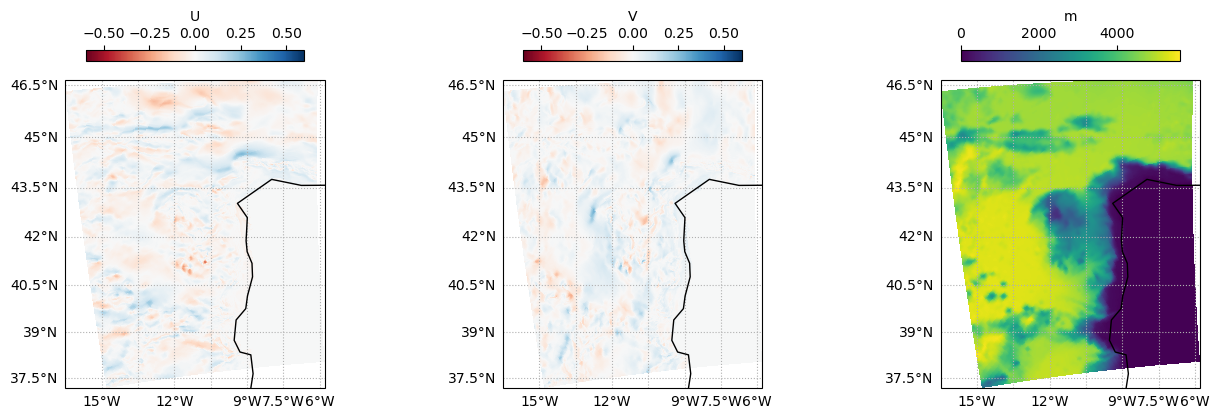

In [34]:
fig=plt.figure(figsize=(16,5))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()
ax1 = fig.add_subplot(1, 3, 1, projection=pr2)
a=ax1.pcolormesh(fieldset.U.grid.lon,fieldset.U.grid.lat,fieldset.U.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='U')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 2, projection=pr2)
a=ax1.pcolormesh(fieldset.V.grid.lon,fieldset.V.grid.lat,fieldset.V.data[0,0,:-1,:-1],shading='flat',transform=pr1,vmin=-0.6,vmax=0.6,cmap=plt.get_cmap('RdBu'))
ax1.coastlines(resolution='110m',zorder=10)
plt.colorbar(a,location='top',shrink=0.6,label='V')
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
ax1 = fig.add_subplot(1, 3, 3, projection=pr2)
a=ax1.pcolormesh(fieldset.H.grid.lon,fieldset.H.grid.lat,fieldset.H.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
plt.colorbar(a,location='top',shrink=0.6,label='m')

In [35]:
fieldset.UV[0,-0.5,39,-12]

(-4.565561357070363e-08, 1.0923911550805054e-07)

In [36]:
# Set min/max depth for float conf, this is to make sure Parcels doesn't struggle 
min_depth = 2.5 #np.ceil(ds['depth_rho'].max(['sig_rho']).min().values)
max_depth = 5800 #int(fieldset.gridset.grids[0].depth.max() / 100)*100
print(min_depth,max_depth)
fieldset.add_constant("vf_surface",min_depth)
fieldset.add_constant("vf_bottom", max_depth)

2.5 5800


In [37]:
fieldset.add_constant("verbose_events",1)

In [41]:
pset = ParticleSet(
    fieldset=fieldset, pclass=ArgoParticle, lon=[-12], lat=[39], depth=[min_depth]
)

In [42]:
kernels = [ArgoFloatKernel, AdvectionRK4_CrocoKevin]

In [43]:
# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(
    kernels,
    runtime=timedelta(days=30),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(name='test_K.zarr', outputdt=timedelta(minutes=30)),
)

INFO: Output files are stored in test_K.zarr.
100%|██████████| 2592000.0/2592000.0 [10:34<00:00, 4082.14it/s]


In [49]:
dout=xr.open_zarr('/home1/datawork/kbalem/test_K.zarr')
dout.load()

<xarray.Dataset> Size: 86kB
Dimensions:       (trajectory: 1, obs: 1440)
Coordinates:
  * obs           (obs) int32 6kB 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
  * trajectory    (trajectory) int64 8B 3
Data variables:
    cycle_age     (trajectory, obs) float32 6kB 300.0 2.1e+03 ... 8.625e+05
    cycle_number  (trajectory, obs) float64 12kB 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0
    cycle_phase   (trajectory, obs) float64 12kB 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0
    in_water      (trajectory, obs) float32 6kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat           (trajectory, obs) float64 12kB 39.0 39.0 39.0 ... 39.73 39.73
    lon           (trajectory, obs) float64 12kB -12.0 -12.0 ... -12.93 -12.93
    time          (trajectory, obs) datetime64[ns] 12kB 2011-01-05T12:00:00 ....
    z             (trajectory, obs) float64 12kB 2.5 164.5 326.5 ... 2.5 2.5 2.5
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4_CrocoKevin
    parcels_mesh:           spherical
    parcels_version:        3.1.0

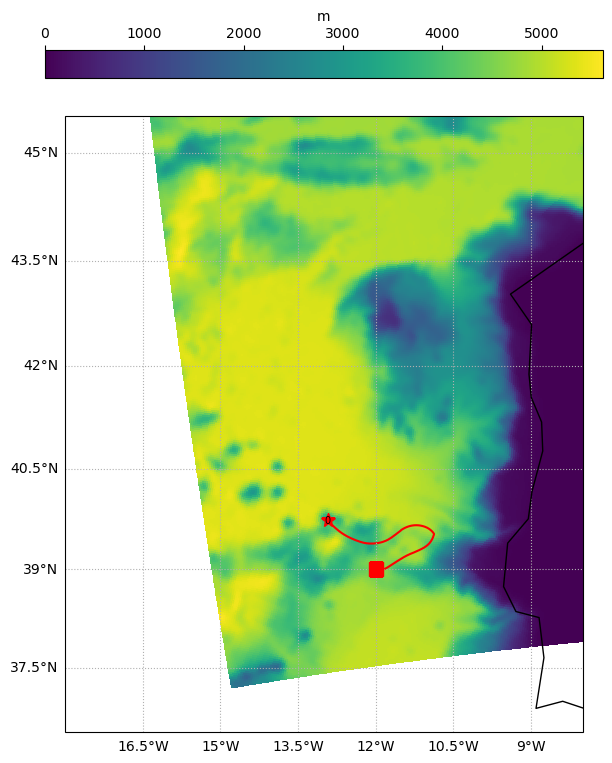

In [53]:
extent = [-18,-8,36.5,45.5]

fig=plt.figure(figsize=(12,10))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()

ax1 = fig.add_subplot(projection=pr2)
a=ax1.pcolormesh(fieldset.H.grid.lon,fieldset.H.grid.lat,fieldset.H.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'rs',markersize=10,transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'r',transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',markersize=10,transform=pr1)
    ax1.text(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),str(t),transform=pr1,ha='center',va='center',size='x-small')
plt.colorbar(a,location='top',shrink=0.6,label='m')
ax1.set_extent(extent)

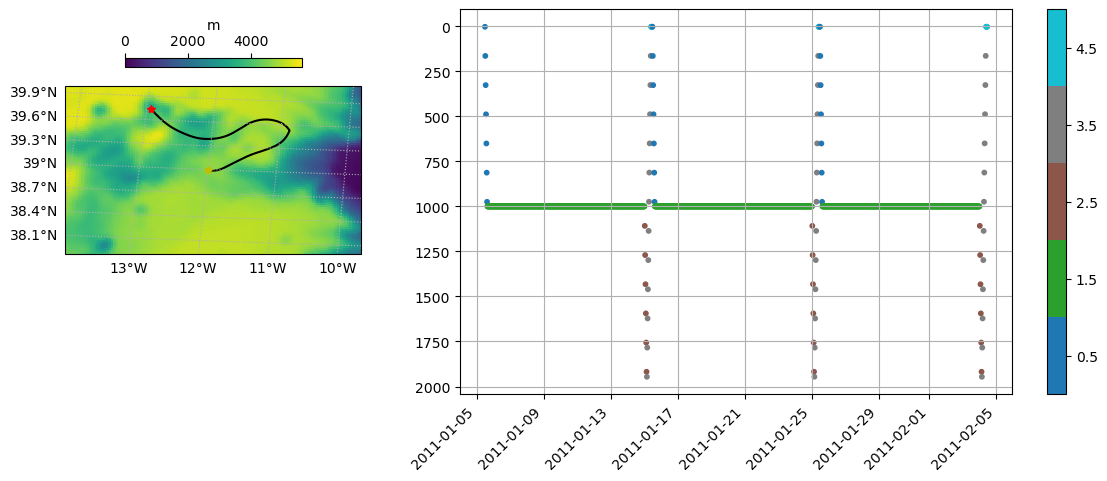

In [52]:
tr=0

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
a=ax1.pcolormesh(fieldset.H.grid.lon,fieldset.H.grid.lat,fieldset.H.data[0,:-1,:-1],shading='flat',transform=pr1,cmap=plt.get_cmap('viridis'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'y*',transform=pr1,zorder=10)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'k',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1,zorder=10)
extent=[dout['lon'].isel(trajectory=tr).min().values -2,
        dout['lon'].isel(trajectory=tr).max().values +2,
        dout['lat'].isel(trajectory=tr).min().values -2,
        dout['lat'].isel(trajectory=tr).max().values +2]
ax1.set_extent([dout['lon'].isel(trajectory=tr).min()-1,
               dout['lon'].isel(trajectory=tr).max()+1,
               dout['lat'].isel(trajectory=tr).min()-1,
               dout['lat'].isel(trajectory=tr).min()+1])
plt.colorbar(a,location='top',shrink=0.6,label='m')

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2008-05-01'),np.datetime64('2008-05-20')])
plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])